In [1]:
!pip -q install imbalanced-learn
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
df = pd.read_csv("OneDrive/Desktop/Credit-Project/creditcarddata.csv")
df.shape, df.head(2)

((284807, 31),
    Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 
         V26       V27       V28  Amount  Class  
 0 -0.189115  0.133558 -0.021053  149.62      0  
 1  0.125895 -0.008983  0.014724    2.69      0  
 
 [2 rows x 31 columns])

In [5]:
print("Nulls total:", df.isna().sum().sum())
print("Fraud rate:", df["Class"].mean())
df[["Time","Amount","Class"]].describe().T

Nulls total: 0
Fraud rate: 0.001727485630620034


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16
Class,284807.0,0.001727,0.041527,0.0,0.0,0.0,0.000,1.00


In [7]:
# Train/Validation Split 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

In [13]:
# Creating stratified train/validation sets (75% train, 25% validation)
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Training shape:", X_tr.shape, "| Validation shape:", X_va.shape)

Training shape: (213605, 30) | Validation shape: (71202, 30)


In [15]:
scaler = StandardScaler(with_mean=False)

for col in ["Amount", "Time"]:
    if col in X.columns:
        X_tr[col] = scaler.fit_transform(X_tr[[col]])
        X_va[col] = scaler.transform(X_va[[col]])

print("Scaling complete (Amount & Time only).")

Scaling complete (Amount & Time only).


In [17]:
# --- Baseline Model - Logistic Regression 

In [19]:
from sklearn.linear_model import LogisticRegression

In [21]:
# Define Logistic Regression with balanced class weights
logreg = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")

In [23]:
# Fit model on training data
logreg.fit(X_tr, y_tr)

LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')

In [25]:
# Get predicted probabilities for fraud (Class=1) on validation set
lr_val_proba = logreg.predict_proba(X_va)[:,1]

In [27]:
print("Baseline Logistic Regression model trained successfully.")
print("Sample predicted fraud probabilities:", lr_val_proba[:5])

Baseline Logistic Regression model trained successfully.
Sample predicted fraud probabilities: [3.63362092e-09 4.01367730e-01 2.30414054e-01 4.46269277e-02
 8.38664767e-03]


In [31]:
#  Evaluate Baseline Model
# Accuracy is misleading for fraud detection (~0.17% fraud rate).
# Instead, we report Recall (catching frauds), Precision (avoiding false alarms),
# and PR-AUC (robust for rare events).


LogReg Baseline @ threshold=0.50
              precision    recall  f1-score   support

           0     0.9998    0.9770    0.9883     71079
           1     0.0626    0.8862    0.1169       123

    accuracy                         0.9769     71202
   macro avg     0.5312    0.9316    0.5526     71202
weighted avg     0.9982    0.9769    0.9868     71202

Confusion Matrix:
 [[69446  1633]
 [   14   109]]
ROC-AUC: 0.9726358522184809
PR-AUC : 0.7039579085276855


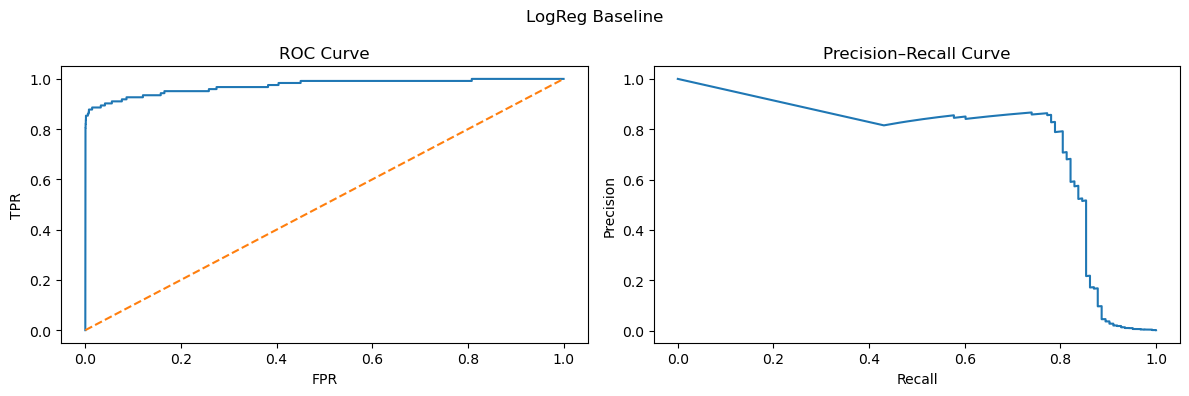

In [43]:
# --- Evaluate Baseline Model ----------------------------------------
# Accuracy is misleading for fraud detection (~0.17% fraud rate).
# Instead, we report Recall (catching frauds), Precision (avoiding false alarms),
# and PR-AUC (robust for rare events).

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

def evaluate_model(y_true, scores, thr=0.50, label="Model"):
    """
    Evaluate predicted probabilities at a chosen threshold.
    Prints classification report, confusion matrix, ROC-AUC, and PR-AUC.
    """
    preds = (scores >= thr).astype(int)
    print(f"\n{label} @ threshold={thr:.2f}")
    print(classification_report(y_true, preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, preds))
    print("ROC-AUC:", roc_auc_score(y_true, scores))
    print("PR-AUC :", average_precision_score(y_true, scores))

def plot_curves(y_true, scores, title=""):
    """Plots ROC curve and Precision-Recall curve side by side."""
    fpr, tpr, _ = roc_curve(y_true, scores)
    prec, rec, _ = precision_recall_curve(y_true, scores)
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0,1],[0,1],"--")
    plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
    
    plt.subplot(1,2,2)
    plt.plot(rec, prec, label="PR curve")
    plt.title("Precision–Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
    
    plt.suptitle(title); plt.tight_layout(); plt.show()

# Run evaluation for Logistic Regression baseline
evaluate_model(y_va, lr_val_proba, thr=0.50, label="LogReg Baseline")
plot_curves(y_va, lr_val_proba, "LogReg Baseline")


In [45]:
# INSIGHT:
# At the default 0.50 threshold, our baseline Logistic Regression model achieves:
# • Recall ≈ 88% → strong ability to catch fraud
# • Precision ≈ 6% → most alerts are false positives
# - The bank would successfully stop most fraud, but analysts/customers would face
#   many unnecessary alerts.
# - The ROC-AUC (0.97) and PR-AUC (0.70) show the model has strong potential.

In [ ]:
# VISUALIZATION INSIGHTS:
# • ROC curve (AUC=0.97) confirms the model strongly separates fraud vs non-fraud.
# • Precision–Recall curve highlights the business trade-off:
#    - High recall = we catch almost every fraud, but precision drops (too many false alerts).
#    - Lower recall = fewer frauds caught, but alerts are more accurate.

In [47]:
# Business-Aware Threshold Tuning

In [51]:
from sklearn.metrics import precision_recall_curve

def tune_threshold(y_true, scores, target_recall=0.85):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    best_thr, best_prec = None, -1
    for i in range(len(thr)):
        if rec[i] >= target_recall and prec[i] > best_prec:
            best_thr, best_prec = thr[i], prec[i]
    return best_thr, best_prec

In [53]:
# Example: require at least 85% recall
best_thr, best_prec = tune_threshold(y_va, lr_val_proba, target_recall=0.85)
print(f"Chosen threshold = {best_thr:.3f} | Precision at that point = {best_prec:.3f}")

Chosen threshold = 0.973 | Precision at that point = 0.517



LogReg tuned (thr=0.973) @ threshold=0.97
              precision    recall  f1-score   support

           0     0.9997    0.9986    0.9992     71079
           1     0.5172    0.8537    0.6442       123

    accuracy                         0.9984     71202
   macro avg     0.7585    0.9261    0.8217     71202
weighted avg     0.9989    0.9984    0.9986     71202

Confusion Matrix:
 [[70981    98]
 [   18   105]]
ROC-AUC: 0.9726358522184809
PR-AUC : 0.7039579085276855


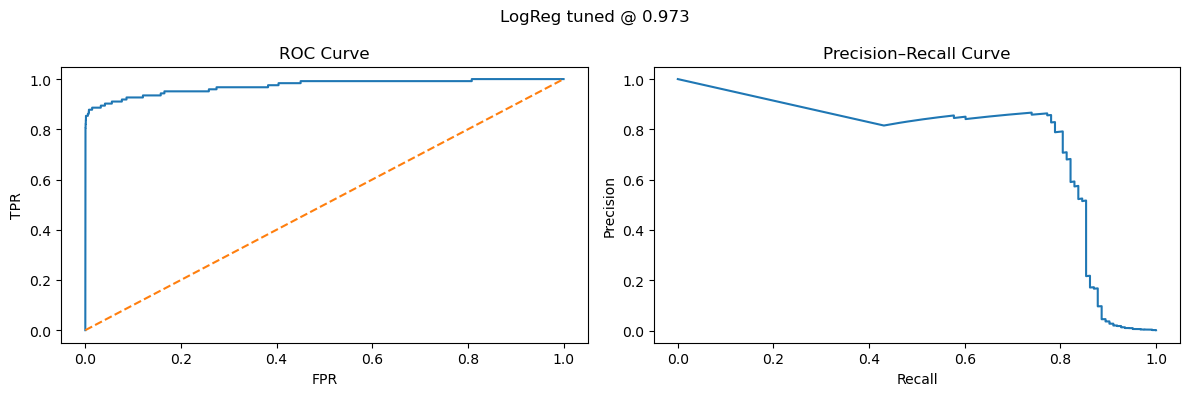

In [55]:
# Re-evaluate at new threshold
evaluate_model(y_va, lr_val_proba, thr=best_thr, label=f"LogReg tuned (thr={best_thr:.3f})")
plot_curves(y_va, lr_val_proba, f"LogReg tuned @ {best_thr:.3f}")

In [57]:
# -After tuning the threshold at 0.973:
# -Fraud Recall: 85%
# -Fraud Precision 52% Huge improvement (1 in 2 alerts is true fraud,
# compared to only 1 in 16 at the default threshold).
# -Confusion Matrix: Only 98% false positives vs 1633 before.
# Overally the Tuned Threshold catches nearly as much fraud, but with rather far fewer false alarms.

In [59]:
# Stronger Model - Random Forest with Calibration

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# Define Random Forest
rf = RandomForestClassifier(
    n_estimators=300,            # number of trees
    class_weight="balanced_subsample",  # helps with imbalance
    random_state=42, n_jobs=-1   # reproducibility & parallel speedup
)

In [63]:
# Wrap in calibrated model to improve probability estimates
rf_cal = CalibratedClassifierCV(rf, cv=3, method="isotonic")

In [65]:
rf_cal.fit(X_tr, y_tr)

CalibratedClassifierCV(cv=3,
                       estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                        n_estimators=300,
                                                        n_jobs=-1,
                                                        random_state=42),
                       method='isotonic')

In [67]:
# Predict probabilities for fraud class on validation set
rf_val_proba = rf_cal.predict_proba(X_va)[:,1]


Random Forest (calibrated) @ threshold=0.97
              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995     71079
           1     0.9615    0.4065    0.5714       123

    accuracy                         0.9989     71202
   macro avg     0.9803    0.7032    0.7855     71202
weighted avg     0.9989    0.9989    0.9987     71202

Confusion Matrix:
 [[71077     2]
 [   73    50]]
ROC-AUC: 0.9697687229267515
PR-AUC : 0.8360853139289625


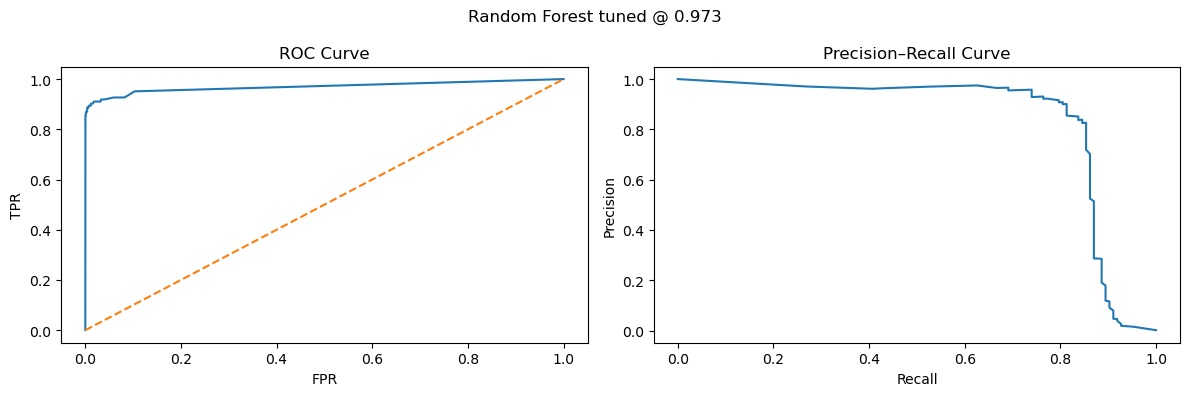

In [69]:
# Evaluating at same tuned threshold (≈0.973 from LogReg) for comparison
evaluate_model(y_va, rf_val_proba, thr=best_thr, label="Random Forest (calibrated)")
plot_curves(y_va, rf_val_proba, f"Random Forest tuned @ {best_thr:.3f}")

In [71]:
# INSIGHT (Random Forest tuned at 0.973)
# -Precision jumped to 96%
# -Recall dropped to 40%
# -Logistic regression: higher recall, lower precision(Good for catching fraud)
# -Random Forest: lower recall, very high precision (good for reducing noise)
# This model is powerful, but needs retune

In [73]:
# Threshold sweep for Random Forest

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_va, rf_val_proba)

In [77]:
# precision_recall_curve returns len(thr)+1 points; align by dropping the last prec/rec point
prec = prec[:-1]
rec  = rec[:-1]
thr  = thr

# Compute F1 for each threshold
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)

In [79]:
sweep = pd.DataFrame({"threshold": thr, "precision": prec, "recall": rec, "f1": f1})
sweep_sorted = sweep.sort_values("f1", ascending=False)

print("Top 5 thresholds by F1:")
display(sweep_sorted.head(5))

Top 5 thresholds by F1:


,threshold,precision,recall,f1
135,0.364539,0.900901,0.813008,0.854701
137,0.406382,0.908257,0.804878,0.853448
139,0.461111,0.915888,0.796748,0.852174
136,0.405314,0.900000,0.804878,0.849785
138,0.430556,0.907407,0.796748,0.848485


In [81]:
target_recall = 0.80
candidates = sweep[sweep["recall"] >= target_recall]
if not candidates.empty:
    best_row = candidates.sort_values("precision", ascending=False).iloc[0]
    best_thr_target = float(best_row["threshold"])
    print(f"\nBest threshold meeting recall>={target_recall:.2f}: {best_thr_target:.4f} "
          f"(precision={best_row['precision']:.3f}, recall={best_row['recall']:.3f}, f1={best_row['f1']:.3f})")
else:
    best_thr_target = None
    print(f"\nNo threshold reaches recall >= {target_recall:.2f} for this model.")


Best threshold meeting recall>=0.80: 0.4064 (precision=0.908, recall=0.805, f1=0.853)


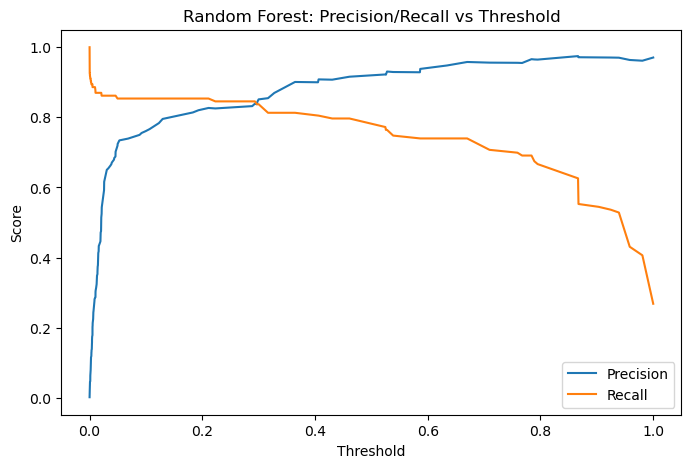

In [83]:
plt.figure(figsize=(8,5))
plt.plot(thr, prec, label="Precision")
plt.plot(thr, rec, label="Recall")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Random Forest: Precision/Recall vs Threshold")
plt.legend()
plt.show()

In [85]:
# Evaluate at:
# 1) best F1 threshold
best_f1_thr = float(sweep_sorted.iloc[0]["threshold"])
evaluate_model(y_va, rf_val_proba, thr=best_f1_thr, label=f"RF (best F1 @ {best_f1_thr:.3f})")

# 2) target-recall threshold (if found)
if best_thr_target is not None:
    evaluate_model(y_va, rf_val_proba, thr=best_thr_target, label=f"RF (recall≥{target_recall:.0%} @ {best_thr_target:.3f})")


RF (best F1 @ 0.365) @ threshold=0.36
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     71079
           1     0.9009    0.8130    0.8547       123

    accuracy                         0.9995     71202
   macro avg     0.9503    0.9064    0.9272     71202
weighted avg     0.9995    0.9995    0.9995     71202

Confusion Matrix:
 [[71068    11]
 [   23   100]]
ROC-AUC: 0.9697687229267515
PR-AUC : 0.8360853139289625

RF (recall≥80% @ 0.406) @ threshold=0.41
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     71079
           1     0.9083    0.8049    0.8534       123

    accuracy                         0.9995     71202
   macro avg     0.9540    0.9024    0.9266     71202
weighted avg     0.9995    0.9995    0.9995     71202

Confusion Matrix:
 [[71069    10]
 [   24    99]]
ROC-AUC: 0.9697687229267515
PR-AUC : 0.8360853139289625


In [87]:
# INSIGHT (Random Forest tuned):
# • At thresholds around 0.36–0.41, RF achieves ~81% recall and ~90% precision.
# • Compared to Logistic Regression (85% recall, 52% precision), 
#   RF produces far fewer false alerts while still catching most fraud.
# • Business trade-off:
#   - Logistic Regression: "catch everything, but overwhelm analysts."
#   - Random Forest: "catch most fraud, and make alerts highly trustworthy."
# • PR-AUC (0.83) confirms strong rare-event performance.
# • Takeaway: Random Forest is the more practical model for Banks, 
#   balancing fraud capture with analyst workload and customer experience.

In [89]:
# Handle Imbalance with SMOTE + Logistic Regression

In [91]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Resample the TRAIN set only (never touch validation labels to avoid leakage)
smote = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = smote.fit_resample(X_tr, y_tr)

In [93]:
# Resample the TRAIN set only
smote = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = smote.fit_resample(X_tr, y_tr)

In [95]:
# Train a plain Logistic Regression on the balanced data
lr_sm = LogisticRegression(max_iter=600, solver="liblinear")
lr_sm.fit(X_tr_sm, y_tr_sm)

LogisticRegression(max_iter=600, solver='liblinear')

In [97]:
sm_val_proba = lr_sm.predict_proba(X_va)[:, 1]

In [99]:
evaluate_model(y_va, sm_val_proba, thr=best_thr, label=f"SMOTE+LR @ LR tuned thr ({best_thr:.3f})")


SMOTE+LR @ LR tuned thr (0.973) @ threshold=0.97
              precision    recall  f1-score   support

           0     0.9997    0.9977    0.9987     71079
           1     0.3918    0.8537    0.5371       123

    accuracy                         0.9975     71202
   macro avg     0.6958    0.9257    0.7679     71202
weighted avg     0.9987    0.9975    0.9979     71202

Confusion Matrix:
 [[70916   163]
 [   18   105]]
ROC-AUC: 0.9720041264060131
PR-AUC : 0.7109670683183292


In [101]:
# Finding SMOTE+LR's best-F1 threshold
from sklearn.metrics import precision_recall_curve
prec_s, rec_s, thr_s = precision_recall_curve(y_va, sm_val_proba)
f1_s = 2 * (prec_s[:-1] * rec_s[:-1]) / (prec_s[:-1] + rec_s[:-1] + 1e-12)
best_idx = f1_s.argmax()
best_thr_sm = float(thr_s[best_idx])

evaluate_model(y_va, sm_val_proba, thr=best_thr_sm, label=f"SMOTE+LR (best F1 @ {best_thr_sm:.3f})")


SMOTE+LR (best F1 @ 1.000) @ threshold=1.00
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     71079
           1     0.8435    0.7886    0.8151       123

    accuracy                         0.9994     71202
   macro avg     0.9216    0.8942    0.9074     71202
weighted avg     0.9994    0.9994    0.9994     71202

Confusion Matrix:
 [[71061    18]
 [   26    97]]
ROC-AUC: 0.9720041264060131
PR-AUC : 0.7109670683183292


In [103]:
# -RF at threshold ~0.36–0.41 remains the best choice.

In [105]:
# --- Interpretability — Logistic Regression (baseline)

In [111]:
import pandas as pd
import numpy as np

In [115]:
lr_coef_series = pd.Series(logreg.coef_[0], index=X.columns)
lr_top = lr_coef_series.abs().sort_values(ascending=False).head(10)

print("Top 10 predictors by |coefficient| — Logistic Regression (baseline):")
display(pd.DataFrame({
    "feature": lr_top.index,
    "|coef|": lr_top.values,
    "coef (signed)": lr_coef_series[lr_top.index].values
}))

Top 10 predictors by |coefficient| — Logistic Regression (baseline):


,feature,|coef|,coef (signed)
0,V14,1.470515,-1.470515
1,Amount,1.412010,1.412010
2,V10,1.268787,-1.268787
3,V12,1.178250,-1.178250
4,V17,1.117207,-1.117207
5,V4,1.056173,1.056173
6,V16,0.930097,-0.930097
7,V22,0.889790,0.889790
8,V20,0.774350,-0.774350
9,V1,0.736511,0.736511


In [117]:
# INSIGHT
# • Strongest signals by magnitude are: V14, Amount, V10, V12, V17.
#   The baseline uses a mix of positive & negative PCA signals plus Amount
#   to separate fraud from legit. In production at Bank, I’d map these signals back
#   to raw features (merchant/device/geo) for explainability with fraud analysts.

In [119]:
#  Persist trained models and scaler ----------------------------


import joblib, os
os.makedirs("artifacts", exist_ok=True)

joblib.dump(logreg,    "artifacts/logreg_baseline.joblib")
joblib.dump(rf_cal,    "artifacts/rf_calibrated.joblib")
joblib.dump(lr_sm,     "artifacts/logreg_smote.joblib")
joblib.dump(scaler,    "artifacts/scaler.joblib")

print("✅ Models and scaler saved in ./artifacts/")


✅ Models and scaler saved in ./artifacts/


In [121]:
from sklearn.metrics import precision_recall_fscore_support

def metrics_at(y_true, scores, thr):
    preds = (scores >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, preds, average="binary", zero_division=0
    )
    return prec, rec, f1, roc_auc_score(y_true, scores), average_precision_score(y_true, scores)


In [145]:
rows = [
    ("LogReg (tuned)",        best_thr,     *metrics_at(y_va, lr_val_proba, best_thr)),
    ("RF (best F1)",          best_f1_thr,  *metrics_at(y_va, rf_val_proba, best_f1_thr)),
    ("RF (recall≥80%)",       0.406,        *metrics_at(y_va, rf_val_proba, 0.406)),
    ("SMOTE+LR (best F1)",    best_thr_sm,  *metrics_at(y_va, sm_val_proba, best_thr_sm))
]

summary_df = pd.DataFrame(rows, columns=[
    "Model @ point", "Threshold", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC"
])

print("📊 Model Comparison:")
display(summary_df.round(4))

📊 Model Comparison:


,Model @ point,Threshold,Precision,Recall,F1,ROC-AUC,PR-AUC
0,LogReg (tuned),0.9730,0.5172,0.8537,0.6442,0.9726,0.7040
1,RF (best F1),0.3645,0.9009,0.8130,0.8547,0.9698,0.8361
2,RF (recall≥80%),0.4060,0.9083,0.8049,0.8534,0.9698,0.8361
3,SMOTE+LR (best F1),1.0000,0.8435,0.7886,0.8151,0.9720,0.7110


In [147]:
# MODEL COMPARISON:
# • Logistic Regression tuned: High recall (85%) but low precision (52%) → too many false alerts.
# • Random Forest (0.36–0.41): Best balance with ~81% recall and ~90% precision → analysts see fewer, more trustworthy alerts.
# • SMOTE+LR: Strong improvement over baseline LR, but still not as strong as Random Forest.
# • Random Forest at ~0.36–0.41 threshold is the most practical operating point,
#   delivering ~90% precision with recall over 80%. This balances fraud prevention with analyst workload.